# Use MACS3 API to call peaks for each cluster in PBMC 500 scATAC-seq data

The scATAC-seq data was downloaded from [10X genomics website](https://www.10xgenomics.com/datasets/500-peripheral-blood-mononuclear-cells-pbm-cs-from-a-healthy-donor-next-gem-v-1-1-1-1-standard-2-0-0). The files used in this tutorial are:
- [Clustering analysis](https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_500_nextgem/atac_pbmc_500_nextgem_analysis.tar.gz) for the clustering results
- [Fragments](https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_500_nextgem/atac_pbmc_500_nextgem_fragments.tsv.gz) for the locations of aligned fragments in TSV format
- [Per Barcode Metrics](https://cf.10xgenomics.com/samples/cell-atac/2.0.0/atac_pbmc_500_nextgem/atac_pbmc_500_nextgem_singlecell.csv) for the information of each barcode

## Load the fragment file and build pileup track

We will import the fragment file parser from MACS3.

In [1]:
# %pip install macs3 pandas

from MACS3.IO.Parser import FragParser
from MACS3.IO.BedGraphIO import bedGraphIO
from MACS3.Utilities.Logger import logging

# we can use the pre-configured logging function from MACS3 to monitor memory usage...
logger = logging.getLogger("demo")
info = logger.info
# Note, you can replace `print` with `info` to show the time and memory usage at that moment.


Assume the fragment file is at `atac_pbmc_500_nextgem_fragments.tsv.gz`. Note that MACS3 can directly load gzipped files. We will load the file and build a `PairEndTrack.PETrackII` object, which contains alignment locations, barcodes and counts.

In [2]:
frag_file = FragParser("./atac_pbmc_500_nextgem_fragments.tsv.gz", buffer_size=100000)
petrack = frag_file.build_petrack(max_count=2)
petrack.finalize()

INFO  @ 26 Nov 2025 21:01:13: [202 MB]  1000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:14: [236 MB]  2000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:15: [256 MB]  3000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:15: [277 MB]  4000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:16: [287 MB]  5000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:16: [307 MB]  6000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:17: [324 MB]  7000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:18: [348 MB]  8000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:18: [364 MB]  9000000 fragments parsed 
INFO  @ 26 Nov 2025 21:01:19: [399 MB]  10000000 fragments parsed 


Before we call peaks, let's clean up the data by removing uncommon chromosomes from downstream analysis. Let's check first...

In [3]:
petrack_rlengths = petrack.rlengths
print(list(petrack_rlengths.keys()))

[b'GL000009.2', b'GL000194.1', b'GL000195.1', b'GL000205.2', b'GL000213.1', b'GL000218.1', b'GL000219.1', b'KI270711.1', b'KI270713.1', b'KI270721.1', b'KI270726.1', b'KI270727.1', b'KI270728.1', b'KI270731.1', b'KI270734.1', b'chr1', b'chr10', b'chr11', b'chr12', b'chr13', b'chr14', b'chr15', b'chr16', b'chr17', b'chr18', b'chr19', b'chr2', b'chr20', b'chr21', b'chr22', b'chr3', b'chr4', b'chr5', b'chr6', b'chr7', b'chr8', b'chr9', b'chrX', b'chrY']


Let's only keep chr1 to chrY. In order to do so, we need to construct genomic 'regions' covering the uncommon chromosomes, and then 'exclude' any fragments overlapping with those regions.

In [4]:
from MACS3.Signal.Region import Regions

regions_to_be_excluded = Regions()
for chrom, chrom_length in petrack_rlengths.items():
    if not chrom.startswith(b'chr'): # this rule may not work if you want to exclude chomosome such as chr1_random, so adjust it if it's necessary
        regions_to_be_excluded.add_loc(chrom, 0, chrom_length)

# then use .exclude of PETrackII 
petrack.exclude(regions_to_be_excluded)
petrack.finalize()

Now check the chromosome names again.

In [5]:
petrack_rlengths = petrack.rlengths
print(list(petrack_rlengths.keys()))

[b'chr1', b'chr10', b'chr11', b'chr12', b'chr13', b'chr14', b'chr15', b'chr16', b'chr17', b'chr18', b'chr19', b'chr2', b'chr20', b'chr21', b'chr22', b'chr3', b'chr4', b'chr5', b'chr6', b'chr7', b'chr8', b'chr9', b'chrX', b'chrY']


Now we can check some basic statistics of the loaded data.

In [6]:
print(f"average template length is {petrack.average_template_length}")
print(f"total number of bases is {petrack.total}")

average template length is 153.5265350341797
total number of bases is 17348915


## Call peaks for the entire dataset

Next, we will call peaks for the entire dataset. The first step is to build a pileup track from the alignments. But before that, we can filter out invalid cells/barcodes. For example, we have an `atac_pbmc_500_nextgem_singlecell.csv` file downloaded together with the fragment file which is from the standard 10x pipeline. We want to only keep the cell barcodes with at least 500 usable fragments and at least 25% of total fragments are marked as usable.

In [7]:
import pandas as pd

barcodes = []

# Read the CSV
df = pd.read_csv("./atac_pbmc_500_nextgem_singlecell.csv")

# We keep the cell barcode that 1) is a cell barcode 2) more than 500 usable fragments 3) at least 25% of total fragments are usable
df_pass = df[
    (df["is__cell_barcode"] == 1) & 
    (df["passed_filters"] >= 500) &
    (df["passed_filters"]/df["total"] >= 0.25)]

# Extract barcode values as a list then convert to a set
# Note: we need to encode the string since PETrackII.subset needs bytestrings.
barcodes = set([x.encode() for x in df_pass["barcode"].tolist()])

print("Cell barcodes to be kept:", len(barcodes))

petrack = petrack.subset(barcodes)

Cell barcodes to be kept: 426


Now we can build the pileup signal track of all valid cell barcodes and their fragments.

In [8]:
pileup_track = petrack.pileup_bdg()

In [9]:
pileup_trackmlx = petrack.pileup_bdgmlx()

We can get the sum, total length, maximum, minimum, mean, and standard deviation from the pileup track by using `summary` function.

In [10]:
(pileup_sum, pileup_length, pileup_max, pileup_min, pileup_mean, pileup_std) = pileup_track.summary()
print(f"{pileup_sum=}\n{pileup_length=}\n{pileup_max=}\n{pileup_min=}\n{pileup_mean=}\n{pileup_std=}")

pileup_sum=2085184512.0
pileup_length=3086530883
pileup_max=468.0
pileup_min=0.0
pileup_mean=0.6755754947662354
pileup_std=5.87749719619751


In [11]:
(pileup_sum, pileup_length, pileup_max, pileup_min, pileup_mean, pileup_std) = pileup_trackmlx.summary()
print(f"{pileup_sum=}\n{pileup_length=}\n{pileup_max=}\n{pileup_min=}\n{pileup_mean=}\n{pileup_std=}")

pileup_sum=2085184512.0
pileup_length=3086530883
pileup_max=468.0
pileup_min=0.0
pileup_mean=0.6755754947662354
pileup_std=5.87749719619751


Next, we will call peaks for the entire dataset. Since we are calling peaks for ATAC-seq data, we will use the single whole-genome average pileup value as the background. From above calculation, the average is in the variable `pileup_mean`.

In [12]:
global_bg_track = pileup_track.set_single_value(pileup_mean) # this will return a new track with all values set as `pileup_mean`

In [13]:
global_bg_trackmlx = pileup_trackmlx.set_single_value(pileup_mean) # this will return a new track with all values set as `pileup_mean`

We construct a score track for comparing observed pileup and background. The score track will contain the observed pileup, the background, and scores for each position in the genome.

In [14]:
score_track = pileup_track.make_ScoreTrackII_for_macs(global_bg_track, depth1=100, depth2=100) # Note, depth1 and 2 are the same so there is no need for scaling the values

In [15]:
score_trackmlx = pileup_trackmlx.make_ScoreTrackMLX_for_macs(global_bg_trackmlx, depth1=100, depth2=100) # Note, depth1 and 2 are the same so there is no need for scaling the values

We will use q-score (-log10 q-value) as scores. MACS3 supports the following methods:

- p: -log10 pvalue;
- q: -log10 qvalue;
- l: log10 likelihood ratio (minus for depletion)
- s: symmetric log10 likelihood ratio (for comparing two ChIPs)
- f: log10 fold enrichment
- F: linear fold enrichment
- d: subtraction
- M: maximum
- m: fragment pileup per million reads

To use any of the methods, provide the argument to `change_score_method` with `ord`, as shown in the following example.

In [16]:
%time
score_track.change_score_method(ord('q'))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.15 μs


In [17]:
%time
score_trackmlx.change_score_method(ord('q'))

CPU times: user 0 ns, sys: 1 μs, total: 1 μs
Wall time: 1.91 μs


In [22]:
cutoff_analysis = score_track.cutoff_analysis(min_score=0.5, max_score=50, max_gap=50, min_length=100)

In [ ]:
cutoff_analysis_mlx = score_trackmlx.cutoff_analysis(min_score=0.5, max_score=50, max_gap=50, min_length=100)

: 

In [23]:
print(cutoff_analysis)

score	npeaks	lpeaks	avelpeak
49.51	14905	7098129	476.22
49.01	14905	7098129	476.22
48.51	14905	7098129	476.22
48.02	15122	7258839	480.02
47.53	15122	7258839	480.02
47.03	15122	7258839	480.02
46.53	15367	7424861	483.17
46.04	15367	7424861	483.17
45.54	15367	7424861	483.17
45.05	15629	7599075	486.22
44.56	15629	7599075	486.22
44.06	15876	7780690	490.09
43.56	15876	7780690	490.09
43.07	15876	7780690	490.09
42.58	16167	7972208	493.12
42.08	16167	7972208	493.12
41.58	16167	7972208	493.12
41.09	16454	8169528	496.51
40.60	16454	8169528	496.51
40.10	16454	8169528	496.51
39.60	16739	8372105	500.16
39.11	16739	8372105	500.16
38.62	16739	8372105	500.16
38.12	17062	8587109	503.29
37.62	17062	8587109	503.29
37.13	17062	8587109	503.29
36.63	17418	8807624	505.66
36.14	17418	8807624	505.66
35.65	17803	9047033	508.17
35.15	17803	9047033	508.17
34.65	17803	9047033	508.17
34.16	18192	9296683	511.03
33.67	18192	9296683	511.03
33.17	18192	9296683	511.03
32.67	18617	9559251	513.47
32.18	18617	9559251	513.47

In [21]:
print(cutoff_analysis_mlx)

score	npeaks	lpeaks	avelpeak
49.51	14905	7098129	476.22
49.01	14905	7098129	476.22
48.52	14905	7098129	476.22
48.02	15122	7258839	480.02
47.52	15122	7258839	480.02
47.03	15122	7258839	480.02
46.53	15367	7424861	483.17
46.04	15367	7424861	483.17
45.55	15367	7424861	483.17
45.05	15629	7599075	486.22
44.55	15629	7599075	486.22
44.06	15876	7780690	490.09
43.56	15876	7780690	490.09
43.07	15876	7780690	490.09
42.58	16167	7972208	493.12
42.08	16167	7972208	493.12
41.59	16167	7972208	493.12
41.09	16454	8169528	496.51
40.59	16454	8169528	496.51
40.10	16454	8169528	496.51
39.60	16739	8372105	500.16
39.11	16739	8372105	500.16
38.62	16739	8372105	500.16
38.12	17062	8587109	503.29
37.62	17062	8587109	503.29
37.13	17062	8587109	503.29
36.63	17418	8807624	505.66
36.14	17418	8807624	505.66
35.65	17803	9047033	508.17
35.15	17803	9047033	508.17
34.66	17803	9047033	508.17
34.16	18192	9296683	511.03
33.66	18192	9296683	511.03
33.17	18192	9296683	511.03
32.67	18617	9559251	513.47
32.18	18617	9559251	513.47

Let's read this analysis into pandas table then plot it.

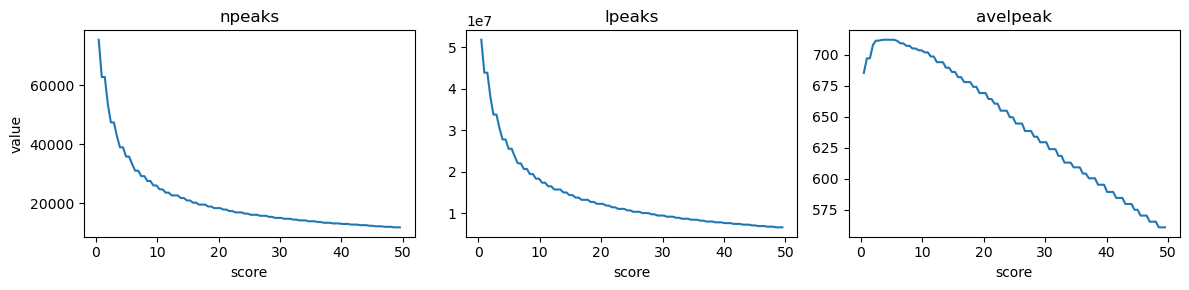

In [15]:
from io import StringIO
import matplotlib.pyplot as plt

cutoff_analysis_df = pd.read_csv(StringIO(cutoff_analysis), sep="\t")
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

axes[0].plot(cutoff_analysis_df["score"], cutoff_analysis_df["npeaks"])
axes[0].set_title("npeaks")
axes[0].set_xlabel("score")
axes[0].set_ylabel("value")

axes[1].plot(cutoff_analysis_df["score"], cutoff_analysis_df["lpeaks"])
axes[1].set_title("lpeaks")
axes[1].set_xlabel("score")

axes[2].plot(cutoff_analysis_df["score"], cutoff_analysis_df["avelpeak"])
axes[2].set_title("avelpeak")
axes[2].set_xlabel("score")

plt.tight_layout()
plt.show()

According to the cutoff analysis, the q-score cutoff 2 (q-value 0.01) seems to be a good cutoff where it seems most of background noises (with smaller q-score) have been removed so the average peak length reaches the maximum.

In [24]:
peaks = score_track.call_peaks(cutoff=2)

In [25]:
peaksmlx = score_trackmlx.call_peaks(cutoff=2)

We can check the number of peaks and the total length of peaks by converting peaks to regions.

In [17]:
# make Regions for peaks from all cell barcodes
regions = Regions()
regions.init_from_PeakIO(peaks)
print(f"Number of peaks: {regions.total}")
print(f"Total basepairs of peaks: {regions.total_length()}")


Number of peaks: 53594
Total basepairs of peaks: 37944522


In [18]:
with open("peaks.narrowPeak","w") as f:
    peaks.write_to_narrowPeak(f)

## Call peaks for the certain cluster of cells

In this section, we will illustrate how to call peaks for a subset of cells from clustering analysis. Assuming that we have clustering results saved in the file 'analysis/clustering/graphclust/clusters.csv'. We downloaded the results from 10X website.

In [19]:
# Read the CSV from clustering analysis
df = pd.read_csv("./analysis/clustering/graphclust/clusters.csv")

# Get barcodes for each cluster
barcodes_cluster_dict = {}
for c in df["Cluster"].unique():
    df_c = df[df["Cluster"] == c]
    barcodes_cluster_dict[c] = set([x.encode() for x in df_c["Barcode"].tolist()])
    print(f"Number of cell barcodes in cluster {c}: {len(barcodes_cluster_dict[c])}")

Number of cell barcodes in cluster 1: 207
Number of cell barcodes in cluster 2: 114
Number of cell barcodes in cluster 4: 57
Number of cell barcodes in cluster 3: 106


In the following analysis, we will focus on cluster 1 and cluster 3.

In [20]:
# Take subset of fragments for c1
petrack_c1 = petrack.subset(barcodes_cluster_dict[1])

# Take subset of fragments for c3
petrack_c3 = petrack.subset(barcodes_cluster_dict[3])

Similar to previous steps, we can generate pileup tracks for these two clusters, make the background tracks, calculate scores, and then call peaks with certain cutoff.

### For Cluster 1

Pile up and construct scoreTrack:

In [21]:
pileup_track_c1 = petrack_c1.pileup_bdg()
global_bg_track_c1 = pileup_track_c1.set_single_value(pileup_track_c1.summary()[4]) 
score_track_c1 = pileup_track_c1.make_ScoreTrackII_for_macs(global_bg_track_c1, depth1=100, depth2=100)
score_track_c1.change_score_method(ord('q'))

Cutoff analysis:

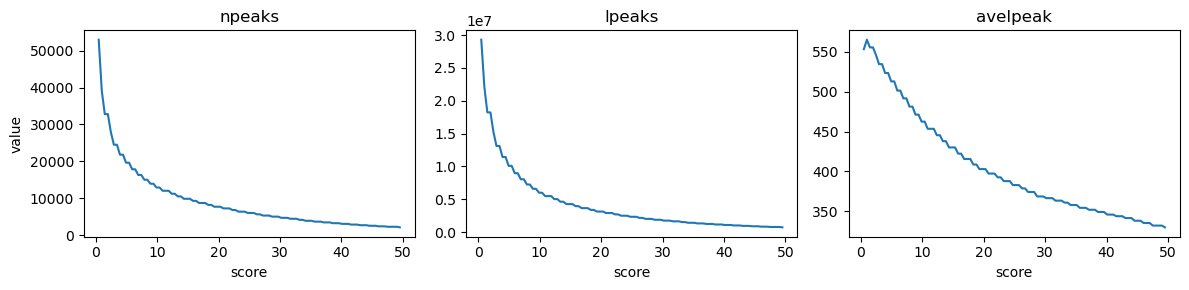

In [22]:
cutoff_analysis_c1 = score_track_c1.cutoff_analysis(min_score=0.5, max_score=50)

cutoff_analysis_df_c1 = pd.read_csv(StringIO(cutoff_analysis_c1), sep="\t")
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

axes[0].plot(cutoff_analysis_df_c1["score"], cutoff_analysis_df_c1["npeaks"])
axes[0].set_title("npeaks")
axes[0].set_xlabel("score")
axes[0].set_ylabel("value")

axes[1].plot(cutoff_analysis_df_c1["score"], cutoff_analysis_df_c1["lpeaks"])
axes[1].set_title("lpeaks")
axes[1].set_xlabel("score")

axes[2].plot(cutoff_analysis_df_c1["score"], cutoff_analysis_df_c1["avelpeak"])
axes[2].set_title("avelpeak")
axes[2].set_xlabel("score")

plt.tight_layout()
plt.show()

According to the analysis, it seems that q-score cutoff of 2 or q-value cutoff of 1e-2 works as a good cutoff.

In [23]:
peaks_c1 = score_track_c1.call_peaks(cutoff=2)

### For Cluster 3

Pile up and construct scoreTrack:

In [24]:
pileup_track_c3 = petrack_c3.pileup_bdg()
global_bg_track_c3 = pileup_track_c3.set_single_value(pileup_track_c3.summary()[4]) 
score_track_c3 = pileup_track_c3.make_ScoreTrackII_for_macs(global_bg_track_c3, depth1=100, depth2=100)
score_track_c3.change_score_method(ord('q'))

Cutoff analysis:

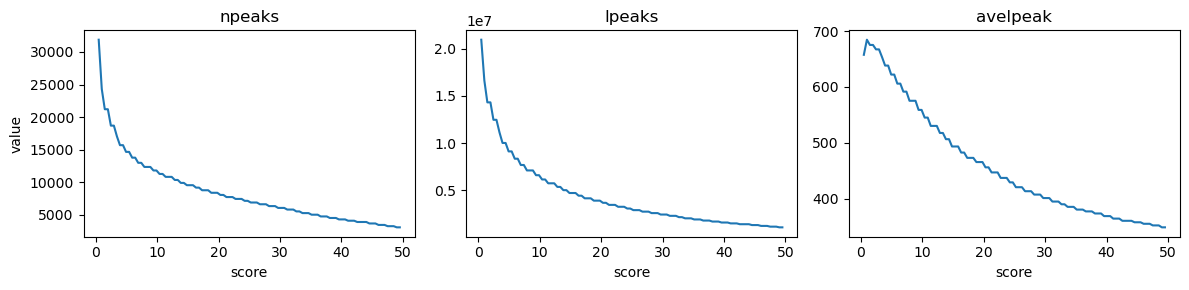

In [25]:
cutoff_analysis_c3 = score_track_c3.cutoff_analysis(min_score=0.5, max_score=50)

cutoff_analysis_df_c3 = pd.read_csv(StringIO(cutoff_analysis_c3), sep="\t")
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

axes[0].plot(cutoff_analysis_df_c3["score"], cutoff_analysis_df_c3["npeaks"])
axes[0].set_title("npeaks")
axes[0].set_xlabel("score")
axes[0].set_ylabel("value")

axes[1].plot(cutoff_analysis_df_c3["score"], cutoff_analysis_df_c3["lpeaks"])
axes[1].set_title("lpeaks")
axes[1].set_xlabel("score")

axes[2].plot(cutoff_analysis_df_c3["score"], cutoff_analysis_df_c3["avelpeak"])
axes[2].set_title("avelpeak")
axes[2].set_xlabel("score")

plt.tight_layout()
plt.show()

According to the analysis, it seems that q-score cutoff of 2 or q-value cutoff of 1e-2 works as a good cutoff.

In [26]:
peaks_c3 = score_track_c3.call_peaks(cutoff=2)

Let's check some basic facts of the peaks called from only the cluster 1 or cluster 3 cell barcodes.

In [27]:
regions_c1 = Regions()
regions_c1.init_from_PeakIO(peaks_c1)
print(f"Number of peaks of cluster 1: {regions_c1.total}")
print(f"Total basepairs of peaks of cluster 1: {regions_c1.total_length()}")

regions_c3 = Regions()
regions_c3.init_from_PeakIO(peaks_c3)
print(f"Number of peaks of cluster 3: {regions_c3.total}")
print(f"Total basepairs of peaks of cluster 3: {regions_c3.total_length()}")

Number of peaks of cluster 1: 32795
Total basepairs of peaks of cluster 1: 18221799
Number of peaks of cluster 3: 21210
Total basepairs of peaks of cluster 3: 14320688


In [28]:
with open("peaks_c1.narrowPeak","w") as f:
    peaks_c1.write_to_narrowPeak(f)

with open("peaks_c3.narrowPeak","w") as f:
    peaks_c3.write_to_narrowPeak(f)

## Compare cluster-specific peaks

We can try to compare these two sets of peaks using functions provided by `Regions` class. Such as get the overlapping regions...

In [29]:
overlapped_regions_c1_c3 = regions_c1.intersect(regions_c3)

print(f"Number of overlapping regions: {overlapped_regions_c1_c3.total}")
print(f"And total basepairs of overlapping regions: {overlapped_regions_c1_c3.total_length()}")

Number of overlapping regions: 15488
And total basepairs of overlapping regions: 9225572


Or unique regions/peaks of cluster 3 that can not be found in the peaks called from cluster 1.

In [30]:
# make Regions for c3 peaks again since later we will alter this object with .exclude function
unique_regions_c3_vs_c1 = Regions()
unique_regions_c3_vs_c1.init_from_PeakIO(peaks_c3)
# then
unique_regions_c3_vs_c1.exclude(regions_c1)

In [31]:
print(f"Peaks of cluster 3 - cluster 1: {unique_regions_c3_vs_c1.total}")
print(f"And total basepairs in peaks of cluster 3 - cluster 1: {unique_regions_c3_vs_c1.total_length()}")

Peaks of cluster 3 - cluster 1: 6661
And total basepairs in peaks of cluster 3 - cluster 1: 2567058


In [32]:
with open("peaks_c3_vs_c1.bed","w") as f:
    unique_regions_c3_vs_c1.write_to_bed(f)